<a href="https://colab.research.google.com/github/alizzi/MagisterIA/blob/main/Trabajo_Practico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico: Planificación de Rutas Logísticas

Grupo:  

*   Germán Pache
*   Fernando Oviedo
*   William Añez
*   Carlos Vizcaya
*   Sebastián Sosa
*   Adrián Lizzi



##Contexto del Problema

Una nueva startup de logística, "TReMR", necesita optimizar las rutas de sus envíos entre varias ciudades. Su objetivo es encontrar la ruta de menor costo para enviar un paquete desde una ciudad de Origen a una ciudad de Destino.
El costo de viajar entre ciudades no es uniforme, ya que depende de la distancia, los peajes y la dificultad del terreno. La red de rutas y sus costos asociados se representa mediante un grafo.

##Objetivo del Trabajo
El objetivo de este trabajo es implementar y comparar cuatro algoritmos de búsqueda (dos no informados y dos informados) para encontrar la ruta de menor costo desde una ciudad de Origen (A) hasta una ciudad de Destino (J).
Deberán utilizar los datos del grafo y las funciones heurísticas proporcionadas para analizar qué algoritmo ofrece la mejor solución en términos de costo y cuál es más eficiente en términos de cómputo.



---


# Imports & Librerías


---



In [ ]:
# Importación de modulos necesarios
import heapq
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.lines as mlines
import math
import copy



---


# Funciones Generales


---



In [ ]:
def uniform_cost_search(grafo, inicio, objetivo):
    cola_prioridad = [(0, inicio, [inicio])]
    visitados = {}

    while cola_prioridad:
        costo, nodo, camino = heapq.heappop(cola_prioridad)

        if nodo in visitados and visitados[nodo] <= costo:
            continue
        visitados[nodo] = costo

        if nodo == objetivo:
            return costo, camino

        for vecino, costo_arista in grafo.get(nodo, []):
            nuevo_costo = costo + costo_arista
            heapq.heappush(cola_prioridad, (nuevo_costo, vecino, camino + [vecino]))

    return float("inf"), []


In [ ]:
def dfs_recursivo(grafo, inicio, objetivo, visitados=None, camino=None):
    if visitados is None:
        visitados = set()
    if camino is None:
        camino = []

    # Marcar nodo actual como visitado
    visitados.add(inicio)
    camino.append(inicio)

    # Si encontramos el objetivo, devolvemos el camino
    if inicio == objetivo:
        return camino

    # Explorar vecinos
    for vecino, _ in grafo.get(inicio, []):
        if vecino not in visitados:
            resultado = dfs_recursivo(grafo, vecino, objetivo, visitados, camino.copy())
            if resultado:  # Si encontró un camino válido
                return resultado

    return None  # Si no hay ruta


In [ ]:
def dfs_iterativo(grafo, inicio, objetivo):
    stack = [(inicio, [inicio])]
    visitados = set()

    while stack:
        nodo, camino = stack.pop()

        if nodo == objetivo:
            return camino

        if nodo not in visitados:
            visitados.add(nodo)
            for vecino, _ in grafo.get(nodo, []):
                if vecino not in visitados:
                    stack.append((vecino, camino + [vecino]))

    return None


In [ ]:
# ===================================
# Función para visualizar ruta
# ===================================
def visualizar_ruta(grafo, heuristica, ruta_encontrada, costo_total, nombre_algoritmo, color_ruta='orange'):
    """
    Genera y muestra un grafo visualizando la ruta encontrada por un algoritmo de búsqueda.
    """
    if not ruta_encontrada:
        print(f"No se encontró una ruta para el algoritmo {nombre_algoritmo}.")
        return

    # Crear el grafo con NetworkX
    G = nx.DiGraph()

    for origen, destinos in grafo.items():
        for destino, peso in destinos:
            G.add_edge(origen, destino, weight=peso)

    # Preparar etiquetas de nodos y aristas
    node_labels = {node: f"{node}\nh={heuristica.get(node, '∞')}" for node in G.nodes()}
    edge_labels = nx.get_edge_attributes(G, 'weight')

    # Obtener aristas del camino seleccionado
    edges_seleccionadas = list(zip(ruta_encontrada, ruta_encontrada[1:]))

    # Identificar inicio y fin
    inicio = ruta_encontrada[0]
    fin = ruta_encontrada[-1]

    # Generar posiciones automáticamente
    posiciones = nx.spring_layout(G, seed=42)

    # Dibujar el grafo
    fig, ax = plt.subplots(figsize=(14, 8))

    # Dibujar todas las aristas posibles en gris
    nx.draw_networkx_edges(G, posiciones, width=2, alpha=0.2, edge_color='gray',
                           connectionstyle='arc3,rad=0.1', ax=ax)

    # Resaltar la ruta seleccionada
    nx.draw_networkx_edges(G, posiciones, edgelist=edges_seleccionadas, width=5, alpha=0.9,
                           edge_color=color_ruta, connectionstyle='arc3,rad=0.1', ax=ax)

    # Dibujar nodos
    nx.draw_networkx_nodes(
        G, posiciones, node_size=2500,
        node_color=['lightgreen' if n == inicio else 'tomato' if n == fin else 'skyblue' for n in G.nodes()],
        edgecolors='black', ax=ax
    )

    # Dibujar etiquetas de nodos y aristas
    nx.draw_networkx_labels(G, posiciones, labels=node_labels, font_size=10, font_weight='bold', ax=ax)
    nx.draw_networkx_edge_labels(G, posiciones, edge_labels=edge_labels, font_size=10, font_weight='bold', ax=ax)

    # Añadir título y leyenda
    ax.set_title(f"Camino Encontrado por {nombre_algoritmo}", fontsize=16, pad=20)
    legend_handles = [
        mlines.Line2D([], [], color=color_ruta, linewidth=5,
                      label=f"Ruta {nombre_algoritmo}: {' → '.join(ruta_encontrada)} (Costo: {costo_total})"),
    ]
    ax.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.1), fontsize=12)

    plt.axis('off')
    plt.show()

In [ ]:
grafo_ciudades = {
    'A': [('B', 5), ('C', 6)],
    'B': [('A', 5), ('D', 7), ('E', 8)],
    'C': [('A', 6), ('F', 12), ('G', 10)],
    'D': [('B', 7), ('E', 3)],
    'E': [('B', 8), ('D', 3), ('I', 10)],
    'F': [('C', 12), ('H', 4)],
    'G': [('C', 10), ('H', 5), ('I', 6)],
    'H': [('F', 4), ('G', 5), ('J', 8)],
    'I': [('E', 10), ('G', 6), ('J', 4)],
    'J': [('H', 8), ('I', 4)],
}




---
# Tarea 1: Implementación de Búsqueda No Informada

1. Búsqueda de Costo Uniforme (UCS): Implementen UCS para encontrar la ruta de menor costo acumulado desde A hasta J. Este algoritmo no utiliza ninguna heurística.
---




Costo mínimo: 26
Ruta óptima: A -> C -> G -> I -> J


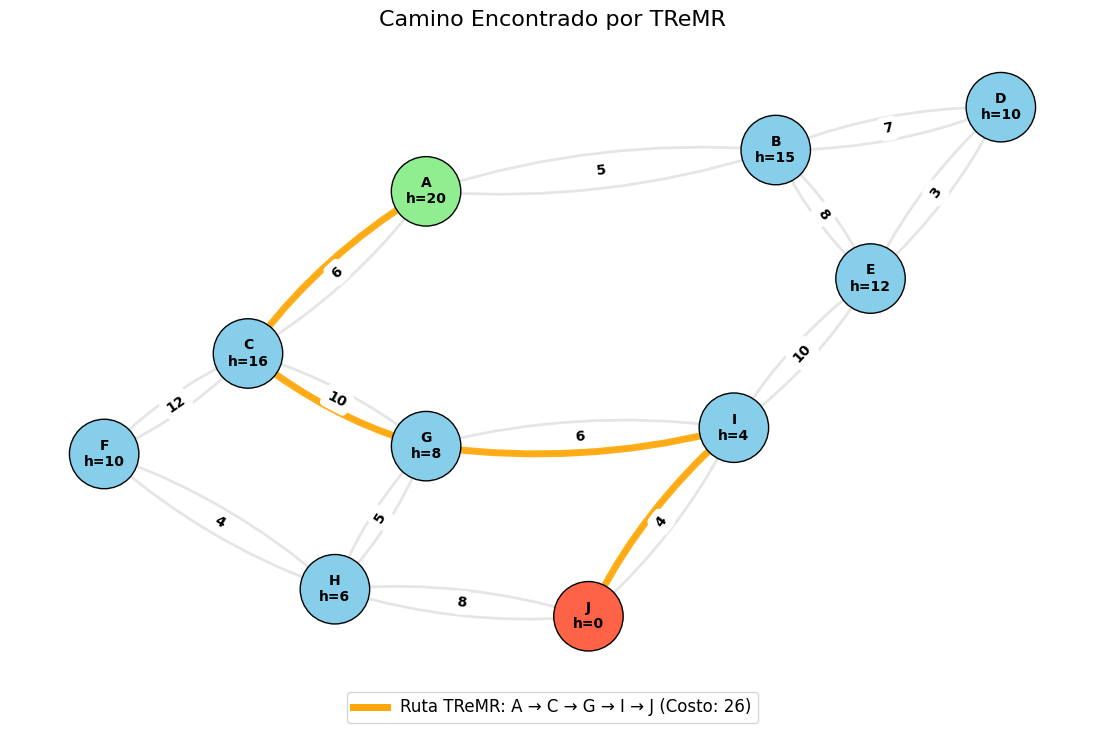

In [ ]:
# ======================
# Ejecución del programa
# ======================
if __name__ == "__main__":
    costo, ruta = uniform_cost_search(grafo_ciudades, "A", "J")
    print("Costo mínimo:", costo)
    print("Ruta óptima:", " -> ".join(ruta))

    heuristica_optimista = {
      'A': 20, 'B': 15, 'C': 16, 'D': 10, 'E': 12,
      'F': 10, 'G': 8,  'H': 6,  'I': 4,  'J': 0
    }

    visualizar_ruta(grafo_ciudades, heuristica_optimista, ruta, costo, 'TReMR', 'orange')


In [ ]:
# DFS recursivo
ruta_dfs = dfs_recursivo(grafo_ciudades, "A", "J")
print("Ruta encontrada con DFS recursivo:", ruta_dfs)

# DFS iterativo
ruta_dfs_iter = dfs_iterativo(grafo_ciudades, "A", "J")
print("Ruta encontrada con DFS iterativo:", ruta_dfs_iter)

Ruta encontrada con DFS recursivo: ['A', 'B', 'D', 'E', 'I', 'G', 'C', 'F', 'H', 'J']
Ruta encontrada con DFS iterativo: ['A', 'C', 'G', 'I', 'J']


Costo mínimo (UCS): 26
Ruta óptima (UCS): A -> C -> G -> I -> J


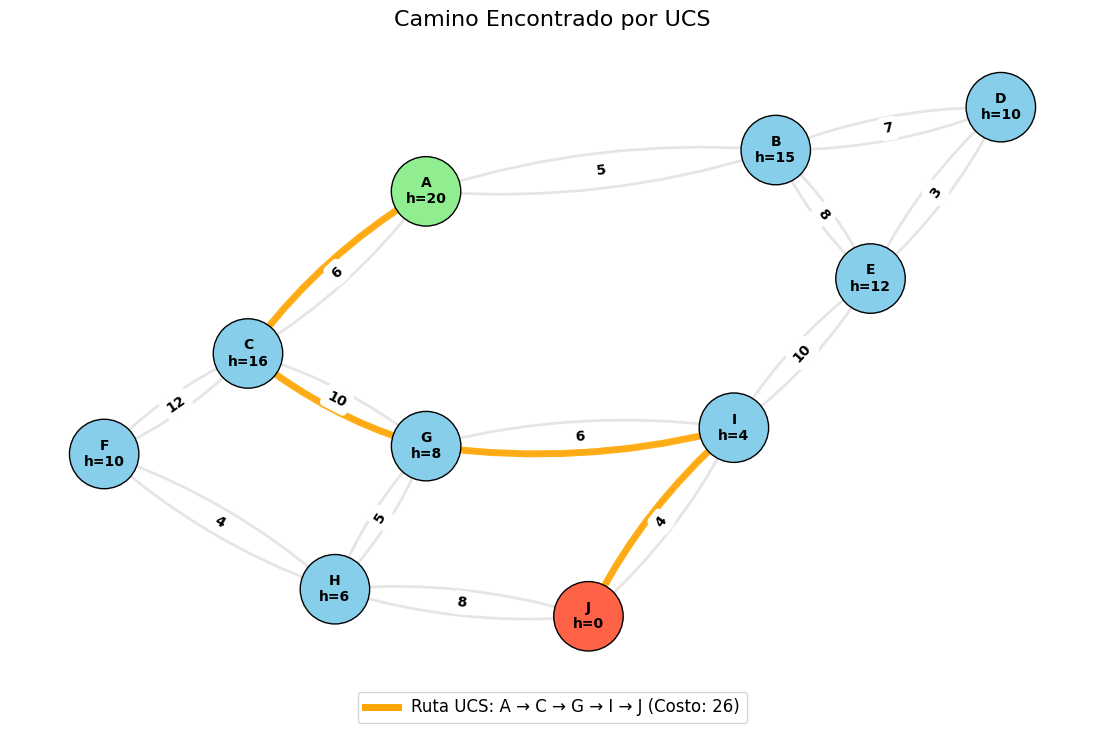

In [ ]:
if __name__ == "__main__":
    # ================= UCS =================
    costo, ruta = uniform_cost_search(grafo_ciudades, "A", "J")
    print("Costo mínimo (UCS):", costo)
    print("Ruta óptima (UCS):", " -> ".join(ruta))

    heuristica_optimista = {
      'A': 20, 'B': 15, 'C': 16, 'D': 10, 'E': 12,
      'F': 10, 'G': 8,  'H': 6,  'I': 4,  'J': 0
    }

    visualizar_ruta(grafo_ciudades, heuristica_optimista, ruta, costo, 'UCS', 'orange')




2.- Búsqueda en Profundidad (DFS): Implementen DFS. Tengan en cuenta que este algoritmo no garantiza encontrar la ruta óptima, sino la primera que encuentre.

Ruta encontrada con DFS: A -> C -> G -> I -> J


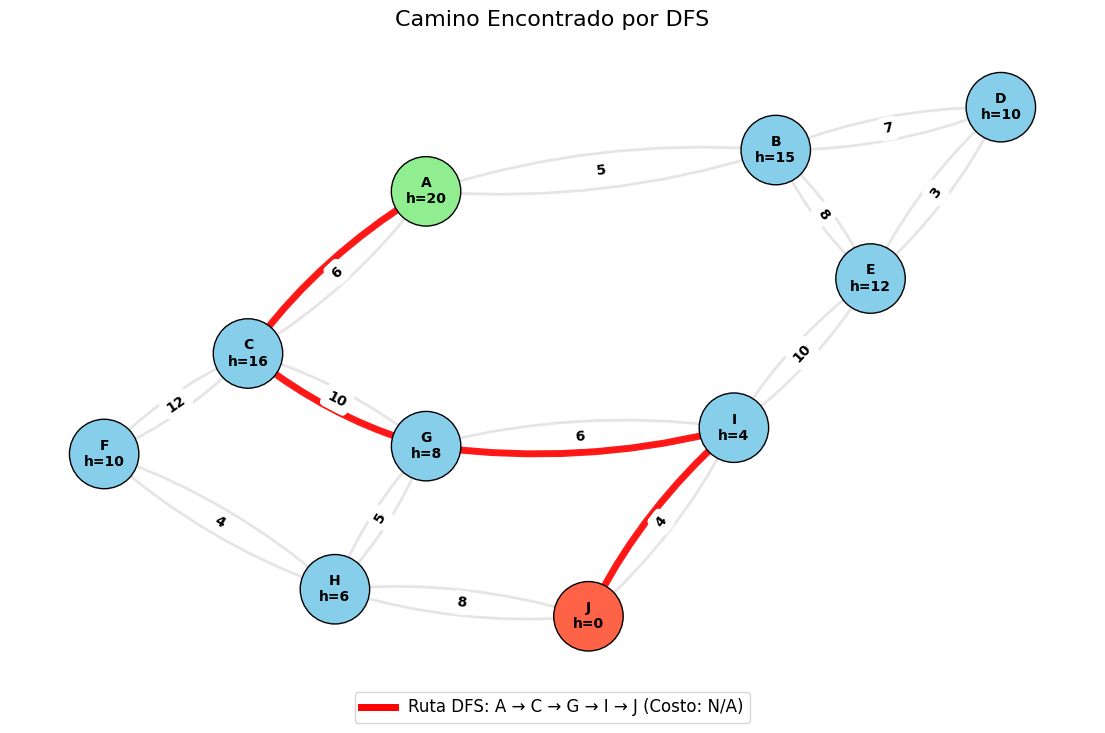

In [ ]:
ruta_dfs = dfs_iterativo(grafo_ciudades, "A", "J")
if ruta_dfs:
    print("Ruta encontrada con DFS:", " -> ".join(ruta_dfs))
    visualizar_ruta(grafo_ciudades, heuristica_optimista, ruta_dfs, "N/A", 'DFS', 'red')

In [ ]:
# Ejecutar los algoritmos y guardar los resultados

resultados = {}

# UCS
ruta_ucs, costo_ucs, nodos_ucs = ucs(grafo_ciudades, ORIGEN, DESTINO)
resultados["UCS"] = {"Ruta": ruta_ucs, "Costo": costo_ucs, "Nodos Expandidos": nodos_ucs}

# DFS
ruta_dfs, costo_dfs, nodos_dfs = dfs(grafo_ciudades, ORIGEN, DESTINO)
resultados["DFS"] = {"Ruta": ruta_dfs, "Costo": costo_dfs, "Nodos Expandidos": nodos_dfs}

# A* con heurística optimista [cite: 31]
ruta_a_star_opt, costo_a_star_opt, nodos_a_star_opt = a_star(grafo_ciudades, ORIGEN, DESTINO, heuristica_optimista)
resultados["A* (Optimista)"] = {"Ruta": ruta_a_star_opt, "Costo": costo_a_star_opt, "Nodos Expandidos": nodos_a_star_opt}

# A* con heurística poco fiable [cite: 33]
ruta_a_star_poco, costo_a_star_poco, nodos_a_star_poco = a_star(grafo_ciudades, ORIGEN, DESTINO, heuristica_poco_fiable)
resultados["A* (Poco Fiable)"] = {"Ruta": ruta_a_star_poco, "Costo": costo_a_star_poco, "Nodos Expandidos": nodos_a_star_poco}

# Imprimir resultados en una tabla [cite: 39]
import pandas as pd
df_resultados = pd.DataFrame(resultados).
print(df_resultados)

SyntaxError: invalid syntax (ipython-input-3062384373.py, line 23)